In [315]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import auc

import sys
sys.path.append("..")

import helper.helper as h
import helper.methods as m
from timeit import default_timer as timer
reload(m)
from notears.notears.notears import utils 
from importlib import reload  # Python 3.4+

In [316]:
def expected_cost_var(W_true, W_est, Sigma = np.identity(p)):
    
    # base on the distribution of X, no actual data needed.    
    covariance_X = np.matmul(np.linalg.inv(np.identity(p ** 2) - np.kron(W_true.T, W_true.T)), Sigma.reshape(p ** 2)).reshape((p, p))
    
    # covariance matrix
    covariance_matrix = Sigma + np.matmul((W_true - W_est).T, np.matmul(covariance_X.T, (W_true - W_est)))
    
    # return expected MSE
    return np.trace(covariance_matrix)

def expected_cost_sem(W_true, W_est, Sigma = np.identity(p)):
    
    # base on the distribution of X, no actual data needed.    
    covariance_matrix = Sigma + (W_true - W_est) @ (W_true - W_est).transpose()
    
    # return expected MSE
    return np.trace(covariance_matrix)

print(f"Difference in MSE between W_OMP and W_true in population setting: {np.round(expected_cost(W_true, W_OMP, np.identity(p)) - expected_cost(W_true, W_true, np.identity(p)), 1)}.")

Difference in MSE between W_OMP and W_true in population setting: 0.6.


True W:
[[ 0.63  0.    0.    0.    0.  ]
 [-0.6   0.    0.    0.    0.  ]
 [ 0.51 -0.63  0.5   0.    0.  ]
 [ 0.    0.75 -0.55  0.65  0.  ]
 [ 0.    0.51 -0.55  0.    0.  ]].

Estimated W:
[[ 0.81  0.    0.    0.    0.  ]
 [ 0.48  0.05  0.17  0.    0.  ]
 [ 0.13  0.   -0.04  0.    0.  ]
 [ 0.34  0.64  0.46  0.53  0.  ]
 [ 0.22  0.52 -0.55  0.74  0.52]].

MSE of W_OMP on test data:	5.163.
MSE on W_true on test data:	4.829.


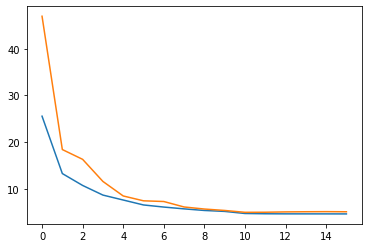

In [317]:
p, s, T = 5, 10, 50
W_true = h.generate_A(p, s, low = 0.5, high = 0.75)
X = h.generate_var_2(T, p, W_true, np.identity(p))

# OMP
W_OMP, Ws, MSEs, max_gains = m._OMP_2(X[:-1], X[1:], output = True)

print(f"True W:\n{np.round(W_true, 2)}.\n")
print(f"Estimated W:\n{np.round(W_KOMP, 2)}.\n")

X_2 = h.generate_var_2(T, p, W_true, np.identity(p))
print(f"MSE of W_OMP on test data:\t{round(h.MSE(W_OMP, X_2), 3)}.")
print(f"MSE on W_true on test data:\t{round(h.MSE(W_true, X_2), 3)}.")

plt.plot(MSEs, label = "MSE on Training Set")
plt.plot(range(0, len(Ws) + 1), np.append(h.MSE(np.zeros((p, p)), X_2), [h.MSE(W, X_2) for W in Ws]), label = "MSE on Test Set")

### Handy Setting: We have test data

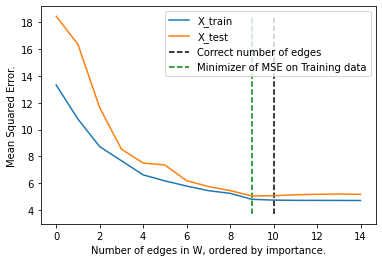

In [329]:
plt.xlabel("Number of edges in W, ordered by importance.")
plt.ylabel("Mean Squared Error.")
plt.plot([h.MSE(W, X) for W in Ws], label = "X_train")
plt.vlines(len(np.nonzero(W_true)[0]), h.MSE(W_OMP, X) - 1, h.MSE(Ws[0], X_2), linestyle = '--', color = 'black', label = "Correct number of edges")
plt.vlines(np.argmin([h.MSE(W, X_2) for W in Ws]), h.MSE(W_OMP, X) - 1, h.MSE(Ws[0], X_2), linestyle = '--', color = 'green', label = "Minimizer of MSE on Training data")
plt.plot([h.MSE(W, X_2) for W in Ws], label = "X_test")
plt.legend()

### Even Better: We have population data / expected cost / a lot of test data

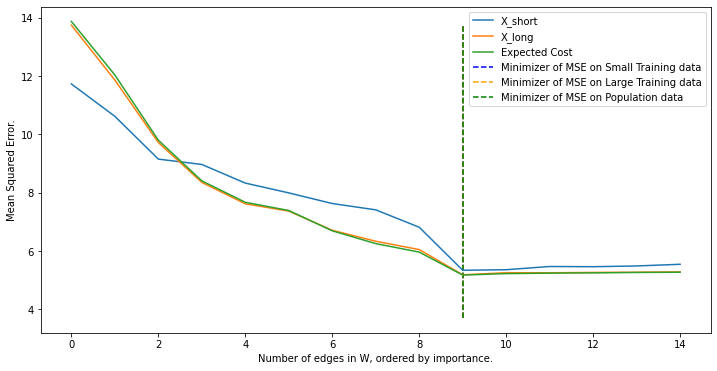

In [339]:
X_short = h.generate_var_2(T, p, W_true, np.identity(p))
X_long = h.generate_var_2(10 * T, p, W_true, np.identity(p))

plt.figure(figsize = (12, 6))
plt.xlabel("Number of edges in W, ordered by importance.")
plt.ylabel("Mean Squared Error.")
plt.plot([h.MSE(W, X_short) for W in Ws], label = "X_short")
plt.plot([h.MSE(W, X_long) for W in Ws], label = "X_long")
plt.vlines(np.argmin([h.MSE(W, X_short) for W in Ws]), h.MSE(W_OMP, X) - 1, h.MSE(Ws[0], X_long), linestyle = '--', color = 'blue', label = "Minimizer of MSE on Small Training data")
plt.vlines(np.argmin([h.MSE(W, X_long) for W in Ws]), h.MSE(W_OMP, X) - 1, h.MSE(Ws[0], X_long), linestyle = '--', color = 'orange', label = "Minimizer of MSE on Large Training data")
plt.vlines(np.argmin([expected_cost_var(W_true, W, Sigma = np.identity(p)) for W in Ws]), h.MSE(W_OMP, X) - 1, h.MSE(Ws[0], X_long), linestyle = '--', color = 'green', label = "Minimizer of MSE on Population data")
plt.plot([expected_cost_var(W_true, W, Sigma = np.identity(p)) for W in Ws], label = "Expected Cost")
plt.legend()

### We have neither, bootstrapping

0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 
Took 38 seconds.


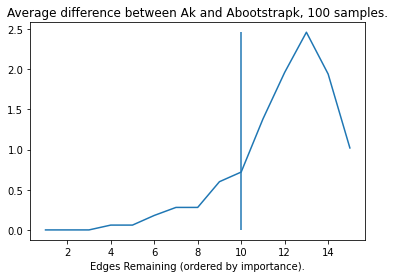

In [341]:
def bootstrap_fast(X, samples = 1):
    W, Ws, mses, max_gains = m._OMP_2(X[:-1], X[1:], output = True)

    diff_bin_avg = []

    for i, W in enumerate(Ws):
        print(i, end = ", ")
        diff_bin = []

        for j in range(samples):
            # generate data according to W
            X_W = h.generate_var_2(T, p, W, np.identity(p))

            # bootstrap, get \hat{W}_k
            bootstrap_W_ii, _, = m._K_OMP(X_W[:-1], X_W[1:], max_coefs = i + 1, normalize = True, F = [])
            
            # difference
            diff_bin.append(np.linalg.norm(((W != 0) ^ (bootstrap_W_ii != 0)).flatten(), 0))

        diff_bin_avg.append(np.sum(diff_bin) / np.shape(diff_bin)[0])

    plt.vlines(s, min(diff_bin_avg), max(diff_bin_avg))
    plt.xlabel("Edges Remaining (ordered by importance).")
    plt.title(f"Average difference between Ak and Abootstrapk, {samples} samples.")
    plt.plot(range(1, len(diff_bin_avg) + 1), diff_bin_avg)
    
    return Ws, diff_bin_avg

start = timer()
Ws, avg = bootstrap_fast(X, samples = 100)
print(f"\nTook {round(timer() - start)} seconds.")

0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 
Took 13 seconds.


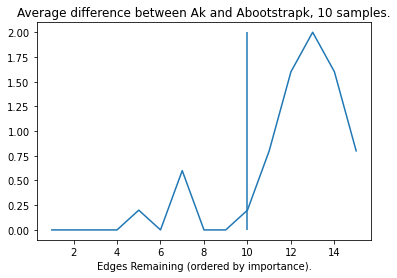

In [251]:
def bootstrap(X, samples = 5):
    W, Ws, mses, max_gains = m._OMP_2(X[:-1], X[1:], output = True)

    diff_bin_avg = []

    for i, W in enumerate(Ws):
        print(i, end = ", ")
        diff_bin = []

        for j in range(samples):
            # generate data according to W
            X_W = h.generate_var_2(T, p, W, np.identity(p))

            # bootstrap, get \hat{W}_k
            _, bootstrap_Ws_i, _, _ = m._OMP_2(X_W[:-1], X_W[1:], output = True)
            bootstrap_W_ii = bootstrap_Ws_i[i]

            # difference
            diff_bin.append(np.linalg.norm(((W != 0) ^ (bootstrap_W_ii != 0)).flatten(), 0))

        diff_bin_avg.append(np.sum(diff_bin) / np.shape(diff_bin)[0])

    plt.vlines(s, min(diff_bin_avg), max(diff_bin_avg))
    plt.xlabel("Edges Remaining (ordered by importance).")
    plt.title(f"Average difference between Ak and Abootstrapk, {samples} samples.")
    plt.plot(range(1, len(diff_bin_avg) + 1), diff_bin_avg)
    
    return Ws, diff_bin_avg

start = timer()
Ws, avg = bootstrap(X, samples = 10)
print(f"\nTook {round(timer() - start)} seconds.")

In [310]:
tol = 3.0
print(np.argmax(np.where(np.array(avg) <= tol)))

14


In [300]:
avg_sum = avg - 0.001 * np.arange(len(avg))

tol = 0.5

print(h.score(X, W_true != 0, Ws[np.argmax((avg <= tol) + 0.001 * np.arange(len(avg)))] != 0))

True Positive Rate: 1.0.
True Negative Rate: 1.0.
False Prediction Rate: 0.0
Accuracy: 1.0.
R-Squared: 0.178
Mean Squared Error: 85.023
(1.0, 1.0, 0.0, 1.0, 0, 85.02301431170864, 0.17751395919470148)


0	10	20	30	40	50	60	70	80	90	

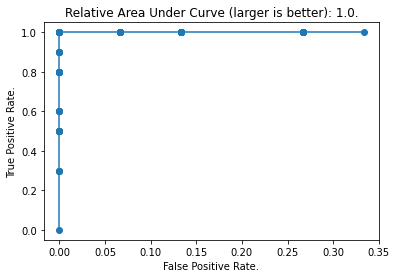

In [343]:
tols = np.linspace(min(avg), max(avg), 100)
tprs, fprs = [0], [0]

B_true = (W_true != 0).flatten()

for i, tol in enumerate(tols):
    if i % 10 == 0: print(i, end = "\t")
        
    B_OMP = (Ws[np.argmax(np.where(np.array(avg) <= tol))] != 0).flatten()

    tprs.append(((B_OMP == B_true) & (B_OMP == 1)).sum() / (B_true == 1).sum())
    fprs.append(((B_OMP != B_true) & (B_OMP == 1)).sum() / (B_true == 0).sum())

plt.xlabel("False Positive Rate.")
plt.ylabel("True Positive Rate.")
plt.plot(fprs, tprs, marker = 'o')

plt.title(f"Relative Area Under Curve (larger is better): {round(auc(fprs, tprs) / (max(tprs) * max(fprs)), 2)}.");

0	10	20	30	40	50	60	70	80	90	

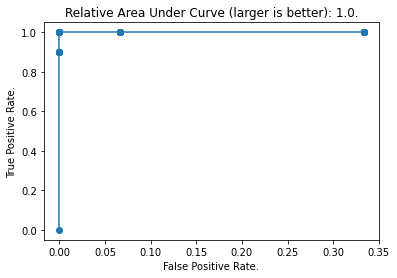

In [313]:
tols = np.linspace(min(avg), 2, 100)
tprs, fprs = [0], [0]

B_true = (W_true != 0).flatten()

for i, tol in enumerate(tols):
    if i % 10 == 0: print(i, end = "\t")
        
    B_OMP = (Ws[np.argmax((avg <= tol) + 0.001 * np.arange(len(avg)))] != 0).flatten()

    tprs.append(((B_OMP == B_true) & (B_OMP == 1)).sum() / (B_true == 1).sum())
    fprs.append(((B_OMP != B_true) & (B_OMP == 1)).sum() / (B_true == 0).sum())

plt.xlabel("False Positive Rate.")
plt.ylabel("True Positive Rate.")
plt.plot(fprs, tprs, marker = 'o')

plt.title(f"Relative Area Under Curve (larger is better): {round(auc(fprs, tprs) / (max(tprs) * max(fprs)), 2)}.");

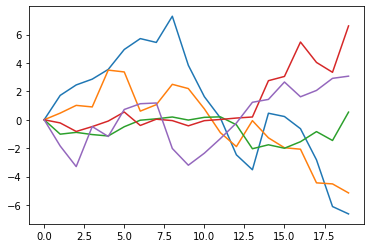

True W:
[[ 0.85  0.    0.    0.    0.  ]
 [ 0.58  0.85  0.    0.    0.  ]
 [-0.74 -0.66  0.85  0.    0.  ]
 [-0.74 -0.73  0.    0.85  0.  ]
 [ 0.68  0.    0.    0.51  0.85]].

Estimated W:
[[ 0.81  0.    0.    0.    0.  ]
 [ 0.48  0.05  0.17  0.    0.  ]
 [ 0.13  0.   -0.04  0.    0.  ]
 [ 0.34  0.64  0.46  0.53  0.  ]
 [ 0.22  0.52 -0.55  0.74  0.52]].

MSE of W_OMP on test data:	13.177.
MSE on W_true on test data:	5.647.


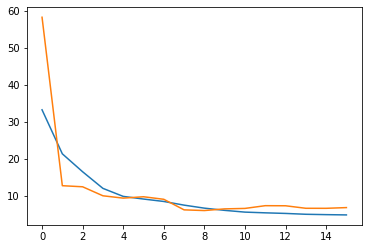

In [180]:
p, s, T = 5, 10, 20
W_true = h.generate_A(p, s, low = 0.5, high = 0.75)

for i in range(p):
    W_true[i][i] = 0.85
    
X = h.generate_var_2(T, p, W_true, np.identity(p))
plt.plot(X)
plt.show()

# OMP
W_OMP, Ws, MSEs, max_gains = m._OMP_2(X[:-1], X[1:], output = True)

print(f"True W:\n{np.round(W_true, 2)}.\n")
print(f"Estimated W:\n{np.round(W_KOMP, 2)}.\n")

X_2 = h.generate_var_2(T, p, W_true, np.identity(p))
print(f"MSE of W_OMP on test data:\t{round(h.MSE(W_KOMP, X_2), 3)}.")
print(f"MSE on W_true on test data:\t{round(h.MSE(W_true, X_2), 3)}.")

plt.plot(MSEs, label = "MSE on Training Set")
plt.plot(range(0, len(Ws) + 1), np.append(h.MSE(np.zeros((p, p)), X_2), [h.MSE(W, X_2) for W in Ws]), label = "MSE on Test Set")

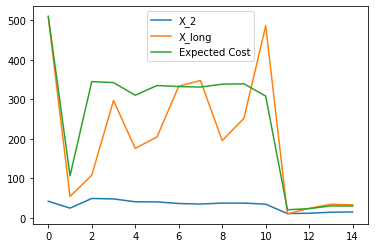

In [174]:
plt.plot([h.MSE(W, X_2) for W in Ws], label = "X_2")
plt.plot([h.MSE(W, h.generate_var_2(10 * T, p, W_true, np.identity(p))) for W in Ws], label = "X_long")
plt.plot([expected_cost_var(W_true, W) for W in Ws], label = "Expected Cost")
plt.legend()